In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [2]:
df = pd.read_csv(r'\Data\Metro_Interstate_Traffic_Volume.csv')

In [3]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [5]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [6]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index,inplace=True)

In [7]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

In [8]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [9]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [10]:
univar_hist_window = 48
horizon = 1
TRAIN_SPLIT = 30000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [11]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]

 Target horizon
[[0.71126374]]


In [12]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [13]:
ED_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_uni.shape[1]), 
    tf.keras.layers.LSTM(units=100,return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))
])
ED_lstm_model.compile(optimizer='adam', loss='mse')


In [14]:
model_path = r'\Chapter 6\LSTM_encoder_decoder_Univarient_2.h5'

In [15]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = ED_lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Train for 100 steps, validate for 50 steps
Epoch 1/150
100/100 [==============================] - 14s 138ms/step - loss: 0.0976 - val_loss: 0.0750
Epoch 2/150
100/100 [==============================] - 2s 24ms/step - loss: 0.0749 - val_loss: 0.0756
Epoch 3/150
100/100 [==============================] - 4s 45ms/step - loss: 0.0712 - val_loss: 0.0640
Epoch 4/150
100/100 [==============================] - 3s 26ms/step - loss: 0.0263 - val_loss: 0.0117
Epoch 5/150
100/100 [==============================] - 2s 24ms/step - loss: 0.0127 - val_loss: 0.0138
Epoch 6/150
100/100 [==============================] - 3s 25ms/step - loss: 0.0111 - val_loss: 0.0091
Epoch 7/150
100/100 [==============================] - 2s 24ms/step - loss: 0.0112 - val_loss: 0.0093
Epoch 8/150
100/100 [==============================] - 2s 25ms/step - loss: 0.0116 - val_loss: 0.0090
Epoch 9/150
100/100 [==============================] - 2s 24ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 10/150
100/100 [===============

In [16]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [17]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 50)            30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 15)                3960      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 15)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 100)            46400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 50)             30200     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              5

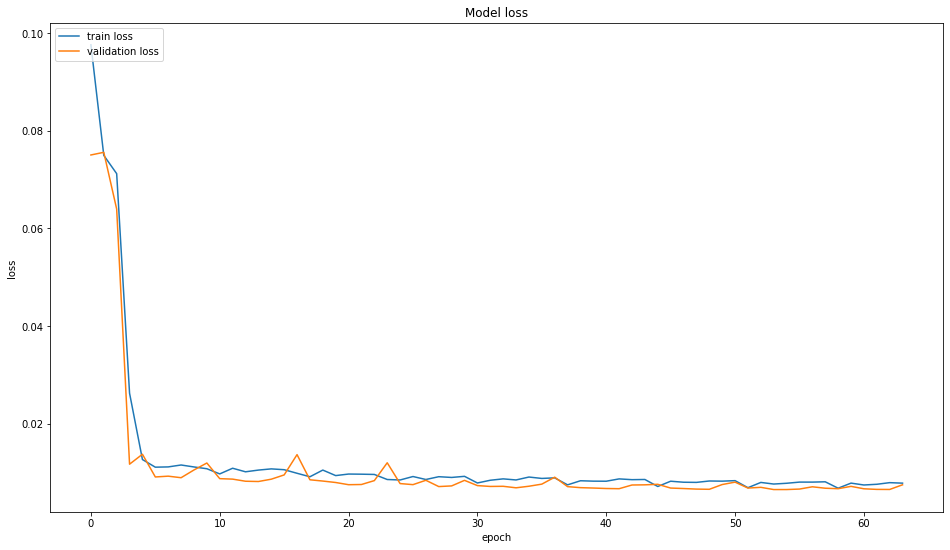

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [20]:
uni = df['traffic_volume']
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = 10
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

for i in range(1, window_len+1):
    
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    print(val_rescaled)


predicted : [[[0.6288946]]]
[0.80830343 0.77960021 0.83000171 0.94020161 1.         0.91576969
 0.81479583 0.67503844 0.54724073 0.46523151 0.40628737 0.54826585
 0.23885187 0.09089356 0.03229113 0.00410046 0.01537673 0.06970784
 0.17495302 0.29062019 0.46779429 0.57919016 0.63625491 0.69075688
 0.73842474 0.72065607 0.73176149 0.72253545 0.75175124 0.77618315
 0.72338971 0.51307022 0.44677943 0.388177   0.60157184 0.25474116
 0.09994874 0.06167777 0.00495472 0.         0.01862293 0.07978814
 0.14351615 0.28481121 0.43516146 0.5750897  0.63454639 0.62889463]
predicted : [[[0.6132983]]]
[0.77960021 0.83000171 0.94020161 1.         0.91576969 0.81479583
 0.67503844 0.54724073 0.46523151 0.40628737 0.54826585 0.23885187
 0.09089356 0.03229113 0.00410046 0.01537673 0.06970784 0.17495302
 0.29062019 0.46779429 0.57919016 0.63625491 0.69075688 0.73842474
 0.72065607 0.73176149 0.72253545 0.75175124 0.77618315 0.72338971
 0.51307022 0.44677943 0.388177   0.60157184 0.25474116 0.09994874
 0.06

In [21]:
result_inv_trans = scaler_x.inverse_transform(np.array(result).reshape(-1,1))

In [22]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [23]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 319288.9216983557
MAE is : 465.131591796875
RMSE is : 565.056565043143
MAPE is : 58.99066693644963
R2 is : 0.7927128261176127



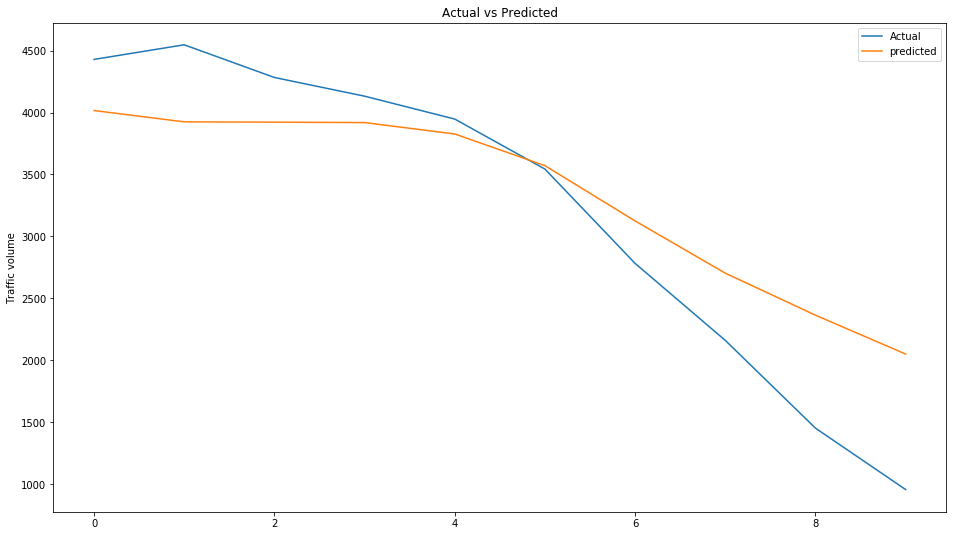

In [24]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()